<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [50]:
import re
from collections import Counter
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import squarify
import pandas as pd
import numpy as np
import spacy

from bs4 import BeautifulSoup
from bs4 import UnicodeDammit
nlp = spacy.load('en_core_web_sm')

## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read through the documentation to accomplish this task. 

In [51]:
from bs4 import BeautifulSoup
import requests
##### Your Code Here #####            
df = pd.read_csv('data/job_listings.csv', index_col=0)
df.head()

,description,title
0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


In [52]:
soup = BeautifulSoup("<div>\nwhatever this is<li>\ntest this \n</li> dang \n</div>")
print(soup.get_text(strip=True))
[text for text in soup.stripped_strings] # this can be a good way to do it

whatever this istest thisdang


['whatever this is', 'test this', 'dang']

In [53]:
b'hello\\r\\n'.decode('utf-8')

'hello\\r\\n'

In [54]:
def clean_data(doc):
    # use beautiful soup to extract text out from tag
    soup = BeautifulSoup(doc[2:-1]) # omit b' '
    doc = soup.get_text()
    # omit b to encode then decode text
    doc = doc.encode().decode('unicode_escape')

    # use regex to only keep alphabet and change multi-space to one space
    non_alpha = '[^a-zA-Z]'
    multi_white_spaces = "[ ]{2,}"
    
    doc = re.sub(non_alpha, ' ', doc)
    doc = re.sub(multi_white_spaces, " ", doc)
    
    return doc.lower().strip()

df['clean_text'] = df['description'].apply(clean_data)

In [56]:
df['clean_text'][0]

'job requirements conceptual understanding in machine learning models like nai ve bayes k means svm apriori linear logistic regression neural random forests decision trees k nn along with hands on experience in at least of them intermediate to expert level coding skills in python r ability to write functions clean and efficient data manipulation are mandatory for this role exposure to packages like numpy scipy pandas matplotlib etc in python or ggplot dplyr tidyr in r ability to communicate model findings to both technical and non technical stake holders hands on experience in sql hive or similar programming language must show past work via github kaggle or any other published article master s degree in statistics mathematics computer science or any other quant specific field apply now'

## 2) Use Spacy to tokenize the listings 

In [57]:
def count(tokens):
    """
    Calculates some basic statistics about tokens in our corpus (i.e. corpus means collections text data)
    """
    # stores the count of each token
    word_counts = Counter()
    
    # stores the number of docs that each token appears in 
    appears_in = Counter()

    total_docs = len(tokens)

    for token in tokens:
        # stores count of every appearance of a token 
        word_counts.update(token)
        # use set() in order to not count duplicates, thereby count the num of docs that each token appears in
        appears_in.update(set(token))

    # build word count dataframe
    temp = zip(word_counts.keys(), word_counts.values())
    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    # rank the the word counts
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    # calculate the percent total of each token
    wc['pct_total'] = wc['count'].apply(lambda token_count: token_count / total * 100)

    # calculate the cumulative percent total of word counts 
    wc = wc.sort_values(by='rank')
    wc['cul_pct_total'] = wc['pct_total'].cumsum()

    # create dataframe for document stats
    t2 = zip(appears_in.keys(), appears_in.values())
    ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
    
    # merge word count stats with doc stats
    wc = ac.merge(wc, on='word')

    wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs * 100)

    return wc.sort_values(by='rank')

In [58]:
STOP_WORDS = nlp.Defaults.stop_words.union(['s','usa'])
# nested list that stores all tokens from all docs
tokens = []
for doc in nlp.pipe(df['clean_text']):
    
    # store tokens from individual docs
    doc_tokens = []

    # iter through the tokens of the doc
    for token in doc:
        # provide stopword and punctuation filters on our tokens
        if ((token.is_punct == False) and (token.text.lower() not in STOP_WORDS) and (token.pos_ != 'PRON')):
            # store doc's tokens in list
            # case normalize our tokens
            doc_tokens.append(token.lemma_.lower().strip())

    # store doc_tokens in our master list    
    tokens.append(doc_tokens)

In [59]:
df['tokens'] = tokens


In [60]:
df.head()

,description,title,clean_text,tokens
0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,job requirements conceptual understanding in m...,"[job, requirement, conceptual, understanding, ..."
1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,job description as a data scientist you will h...,"[job, description, data, scientist, help, buil..."
2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level,as a data scientist you will be working on con...,"[data, scientist, work, consult, business, res..."
3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist,a monthcontractunder the general supervision o...,"[monthcontractunder, general, supervision, pro..."
4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist,location usa multiple locations years of analy...,"[location, multiple, location, year, analytic,..."


In [61]:
wc = count(df['tokens'])

In [62]:
wc.head(10)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
186,datum,419,3076,1.0,2.309934,2.309934,98.356808
69,experience,408,1959,2.0,1.471118,3.781052,95.774648
52,work,385,1663,3.0,1.248836,5.029888,90.375587
31,data,373,1390,4.0,1.043826,6.073714,87.558685
176,team,370,1375,5.0,1.032561,7.106275,86.854460
298,business,325,1265,6.0,0.949956,8.056231,76.291080
55,science,342,989,7.0,0.742693,8.798925,80.281690
29,model,293,909,8.0,0.682617,9.481542,68.779343
209,product,276,896,9.0,0.672855,10.154396,64.788732
327,analytic,263,846,10.0,0.635307,10.789703,61.737089


## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [63]:
##### Your Code Here #####
# instantiate the vectorizer
vect = CountVectorizer(stop_words="english", max_features=1000)

# learn BCC dataset vocab
vect.fit(df['clean_text'])

# create dtm for BCC dataset
dtm = vect.transform(df['clean_text'])

dtm = pd.DataFrame(data=dtm.toarray(),  columns=vect.get_feature_names())

In [64]:
dtm

,abilities,ability,able,academic,access,accommodation,accommodations,accuracy,achieve,acquisition,...,works,world,worldwide,write,writing,written,www,year,years,york
0,0,2,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,0,0,...,0,2,0,0,2,1,0,1,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2,3,1
422,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,1,0,0,0,0,0
423,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,1,0,0,1,0,0
424,0,0,2,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


## 4) Visualize the most common word counts

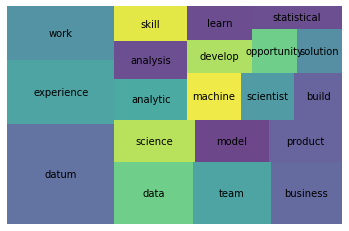

In [65]:
##### Your Code Here #####
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [66]:
def tokenize(document):
    """
    Takes a doc and returns a list of tokens in the form of lemmas.
    Stop words and punctuation are filtered out. 
    """
    
    doc = nlp(document)
    
    return [token.lemma_.strip() for token in doc if (token.is_stop != True) and (token.is_punct != True)]

In [67]:
##### Your Code Here #####
# Instantiate vectorizer object
tfidf_vect = TfidfVectorizer(tokenizer=tokenize)

# Create a vocabulary and get word counts per document
# Similiar to fit_predict
dtm = tfidf_vect.fit_transform(df['clean_text'])

# View Feature Matrix as DataFrame
dtm = pd.DataFrame(data=dtm.toarray(), columns=tfidf_vect.get_feature_names())
dtm

,aa,aap,ab,abernathy,ability,able,abound,abroad,absence,absolutely,...,zero,zeus,zf,zheng,zillow,zogsport,zone,zoom,zuckerberg,zurich
0,0.0,0.0,0.0,0.0,0.092348,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.021569,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.069630,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.113887,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,0.0,0.0,0.0,0.0,0.029462,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
422,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
423,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.104388,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
424,0.0,0.0,0.0,0.0,0.000000,0.066405,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [97]:
job_listing = ['Job listing: Data Scientist  Proficient coder in Python, JavaScript. Working knowledge in Git [Github, GitLab]. Familiarity with scripting languages, machine learning, advanced statistical techniques, and A/B testing is a plus. Analyze, test, and interpret complex clinical data, algorithmic results, and Machine Learning model performance data. Demonstrated experience with some or all of the following: data modeling, data visualization, statistics, experimental design, predictive modeling.']

In [101]:
a = tfidf_vect.fit_transform(job_listing)

In [103]:
pd.DataFrame(data=a.toarray(), columns=tfidf_vect.get_feature_names())

,,advanced,algorithmic,analyze,b,clinical,coder,complex,datum,demonstrate,...,result,scientist,scripting,statistic,statistical,technique,test,testing,visualization,work
0,0.114708,0.114708,0.114708,0.114708,0.114708,0.114708,0.114708,0.114708,0.573539,0.114708,...,0.114708,0.114708,0.114708,0.114708,0.114708,0.114708,0.114708,0.114708,0.114708,0.114708


In [104]:
doc_index = 1
doc = [dtm.iloc[doc_index].values]

In [105]:
doc

[array([0., 0., 0., ..., 0., 0., 0.])]

In [91]:
##### Your Code Here #####
# Fit on DTM
nn = NearestNeighbors(n_neighbors=5, algorithm='brute')
nn.fit(dtm)

# Query Using kneighbors 
neigh_dist, neigh_index = nn.kneighbors(a)

ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 43 while Y.shape[1] == 6433

In [206]:
neigh_dist

array([[0.        , 1.26458801, 1.2952899 , 1.29533272, 1.2984744 ]])

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 